## Running the gan with different parameters and architectures a evalute the outcomes on small scale simulations.

Import all the thing that you will ever need. In the following cell is better to reload every used module uring development to avoid running on older version.

In [4]:
import numpy as np
import seaborn as sb
import pandas as pd
from random import randint, choice
import torch
from importlib import reload
import os
import glob
from types import SimpleNamespace
import logging

import gan.pix2pix as p2p
import visualization
import gan
import gan.defaults

We define a default set of options to begin with.

In [7]:
# %env CUDA_LAUNCH_BLOCKING=1
reload(p2p)
reload(gan.defaults)
base_opt = gan.defaults.defaults
gm = p2p.many_runs(base_opt, {
    "cuda": True,
    "log_level": "info",
    "generator_depth": (4, 5, 6),
    "num_filters": (2, 4, 8),
})

TypeError: 'bool' object is not iterable

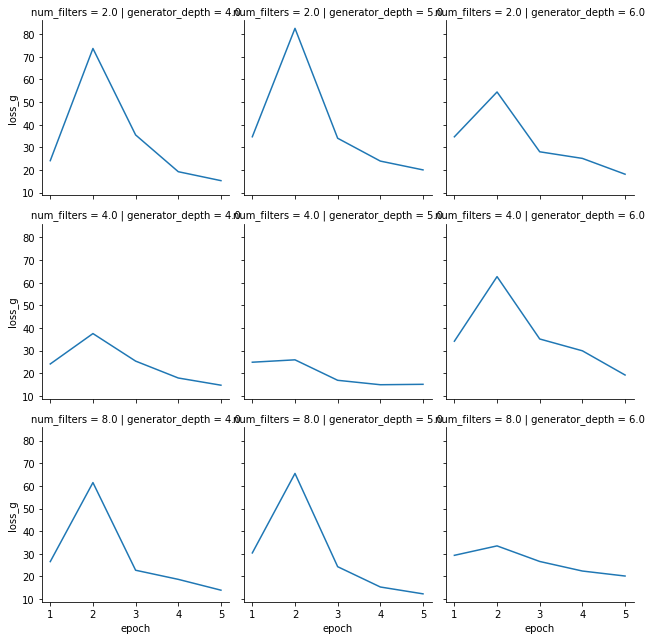

In [ ]:
gm = pd.read_csv("last_run.csv")
g = sb.FacetGrid(gm, col="generator_depth",  row="num_filters")
g.map(sb.lineplot, "epoch", "loss_g")

<AxesSubplot:xlabel='epoch', ylabel='loss_g'>

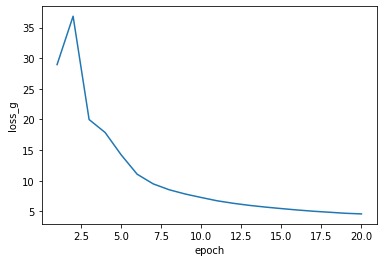

In [18]:
sb.lineplot(data=pd.read_csv("last_run.csv"), x="epoch", y="loss_g")